#Generative adversarial nertworks implementation day--ahead energy price generation

Data sources:
https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/SFTP%20guide.html

Folder -> EnergyPrices_12.1.D_r3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/torch_Training_Vanilla_GANS/"
os.makedirs(save_dir, exist_ok=True)

read_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/"

In [ ]:
pip install torchinfo

In [ ]:
import pandas as pd
import os
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

import time
import pickle

file_paths = [
    os.path.join(read_dir, 'France (FR)2022.csv')
    #os.path.join(read_dir, 'France (FR)2023.csv')
    #os.path.join(read_dir, 'France (FR)2024.csv')
]

data_frames = []

for file_path in file_paths:
    data_frames.append(pd.read_csv(file_path, sep=","))

data = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(data.head())

Hour_values = ['00:00', '01:00', '02:00', '03:00',
       '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00',
       '20:00', '21:00', '22:00', '23:00']

Initial_data = data[Hour_values].to_numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    Date(UTC) AreaDisplayName   00:00   01:00   02:00   03:00   04:00   05:00  \
0  2022-01-01     France (FR)   78.48   85.16   50.00   37.67   39.70   40.59   
1  2022-01-02     France (FR)   52.59   48.97   34.94   29.56   33.97   34.52   
2  2022-01-03     France (FR)    1.71    1.24    0.06    0.09    1.44   41.11   
3  2022-01-04     France (FR)  115.55  113.29  105.81  105.00  115.11  156.91   
4  2022-01-05     France (FR)  105.10   84.50   75.38   79.11   94.79  169.04   

    06:00   07:00  ...   14:00   15:00   16:00   17:00   18:00   19:00  \
0   43.26   49.66  ...   98.52  114.50  149.97  146.33  140.28  121.88   
1   41.80   48.95  ...   39.30   40.79   47.91   65.09   67.85   62.22   
2   90.54  161.79  ...  112.87  126.80  148.49  175.06  180.00  146.43   
3  182.64  178.91  ...  180.93  166.69  189.88  184.94  178.99  156.12   
4  215.98  211

In [ ]:
def normalize_column_minmax(column):
    min_price = column.min()
    max_price = column.max()
    normalized_column = (column - min_price) / (max_price - min_price)

    # Store normalization parameters
    normalization_params_minmax[column.name] = {'min_price': min_price, 'max_price': max_price}

    return normalized_column

# Dictionary to store normalization parameters
normalization_params_minmax = {}

normalized_data_minmax = data[Hour_values].apply(normalize_column_minmax, axis=0)

normalization_params_minmax_df = pd.DataFrame.from_dict(normalization_params_minmax, orient='index')

data_normalized_minmax = data.copy()
data_normalized_minmax[Hour_values] = normalized_data_minmax

In [ ]:
if data_normalized_minmax[Hour_values].isna().any().any():
    print("⚠️ ALERT: One or more columns in Hour_values contain NaN values!")
else:
    print("✅ All columns in Hour_values are free of NaN values.")

Training_data = data_normalized_minmax[Hour_values].to_numpy()
print('Training_data.shape ', Training_data.shape)

✅ All columns in Hour_values are free of NaN values.
Training_data.shape  (365, 24)


In [ ]:
# Hyperparameters
latent_dim = 100          # Size of random noise vector
input_dim = 24            # 24-hour prices for a day
epochs = 5*10**4
batch_size = 32

# Create training dataset
train_data = torch.tensor(Training_data, dtype=torch.float32)
dataset_torch = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()          # To generate [0,1]--normalized data
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()          # Output probability
        )
    def forward(self, x):
        return self.model(x)

def discriminator_loss(real_output, fake_output):
    real_loss = -torch.mean(torch.log(real_output + 1e-12))
    fake_loss = -torch.mean(torch.log(1 - fake_output + 1e-12))
    return real_loss + fake_loss          #Average?

def generator_loss(fake_output):
    return -torch.mean(torch.log(fake_output + 1e-12))

# Build and compile the models
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

print(summary(generator, input_size=(batch_size, latent_dim)))
print(summary(discriminator, input_size=(batch_size, input_dim)))

# Training functions
def train_discriminator(discriminator, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    real_output = discriminator(real_data)
    fake_output = discriminator(fake_data)
    loss = discriminator_loss(real_output, fake_output)
    loss.backward()
    optimizer.step()
    return loss

def train_generator(generator, discriminator, noise, optimizer):
    optimizer.zero_grad()
    fake_data = generator(noise)
    fake_output = discriminator(fake_data)
    loss = generator_loss(fake_output)
    loss.backward()
    optimizer.step()
    return loss

def summarize_performance_discriminator(generator, discriminator, Training_data, latent_dim, n_samples):
    # Randomly select n_samples from Training_data
    indices = np.random.RandomState(seed=42).choice(Training_data.shape[0], size=n_samples, replace=False)
    X_real = Training_data[indices]
    y_real = np.ones((n_samples, 1))  # Label 1 for real samples

    # Prepare fake samples
    noise = torch.randn(n_samples, latent_dim)
    X_fake = generator(noise)
    y_fake = np.zeros((n_samples, 1))  # Label 0 for fake samples

    # Evaluate discriminator on real samples
    real_output = discriminator(torch.tensor(X_real, dtype=torch.float32))
    real_accuracy = np.mean((real_output.detach().numpy() > 0.5).astype(int) == y_real)

    # Evaluate discriminator on fake samples
    fake_output = discriminator(X_fake)
    fake_accuracy = np.mean((fake_output.detach().numpy() <= 0.5).astype(int) == y_fake)  # Convert fake_output to NumPy array for comparison

    return real_accuracy, fake_accuracy

def train_gan(generator, discriminator, dataset_torch, epochs, latent_dim):
  optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
  optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

  g_losses, d_losses = [], []
  real_accuracy_v, fake_accuracy_v = [], []
  real_accuracy, fake_accuracy = 0.0, 0.0

  start_time = time.time()
  for epoch in range(epochs):
    for batch in dataset_torch:
      real_data = batch[0]
      batch_size = real_data.size(0)

      # Generate random noise for fake data
      noise = torch.randn(batch_size, latent_dim)
      fake_data = generator(noise)

      # Train Discriminator
      d_loss = train_discriminator(discriminator, real_data, fake_data, optimizer_d)
      d_losses.append(d_loss.item())

      # Train Generator
      noise = torch.randn(batch_size, latent_dim)
      g_loss = train_generator(generator, discriminator, noise, optimizer_g)
      g_losses.append(g_loss.item())

    # Calculate elapsed time
    elapsed_time = int(time.time() - start_time)
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    elapsed_time_str = f"{hours:02}:{minutes:02}:{seconds:02}"  # Format hh:mm:ss

    # Calculate percentage completion
    percentage = (epoch + 1) / epochs * 100
    if (epoch+1) % 100 == 0:
      real_accuracy, fake_accuracy = summarize_performance_discriminator(generator, discriminator, Training_data, latent_dim, n_samples=100)
      real_accuracy_v.append(real_accuracy)
      fake_accuracy_v.append(fake_accuracy)

    print(f"\rGLoss: {g_loss.item():.4f}: Training: {percentage:.0f}% - Accuracy: {real_accuracy*100:.0f}% real as real, {fake_accuracy*100:.0f}% fake as fake - Elapsed Time: {elapsed_time_str}", end='')

  return g_losses, d_losses, real_accuracy_v, fake_accuracy_v

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 24]                  --
├─Sequential: 1-1                        [32, 24]                  --
│    └─Linear: 2-1                       [32, 64]                  6,464
│    └─ReLU: 2-2                         [32, 64]                  --
│    └─Linear: 2-3                       [32, 128]                 8,320
│    └─ReLU: 2-4                         [32, 128]                 --
│    └─Linear: 2-5                       [32, 24]                  3,096
│    └─Sigmoid: 2-6                      [32, 24]                  --
Total params: 17,880
Trainable params: 17,880
Non-trainable params: 0
Total mult-adds (M): 0.57
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.07
Estimated Total Size (MB): 0.14
Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1]                   --


GLoss: 0.6403: Training: 100% - Accuracy: 76% real as real, 77% fake as fake - Elapsed Time: 00:51:30✅


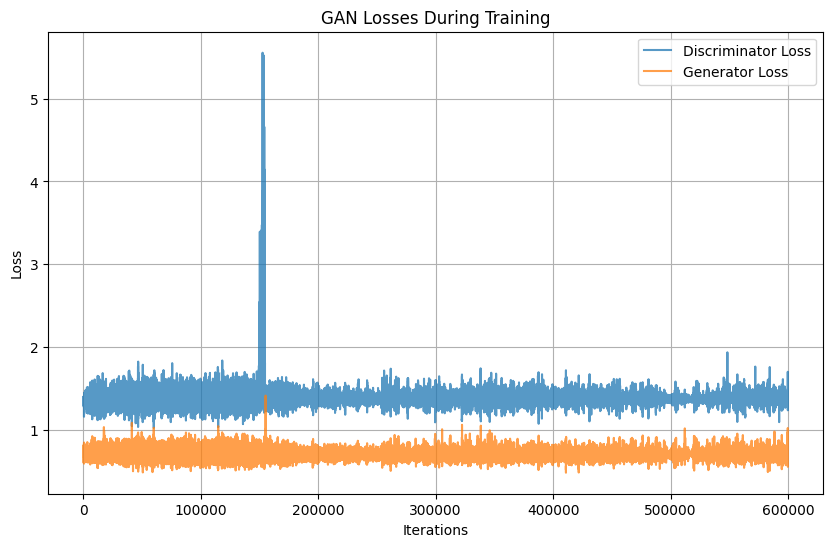

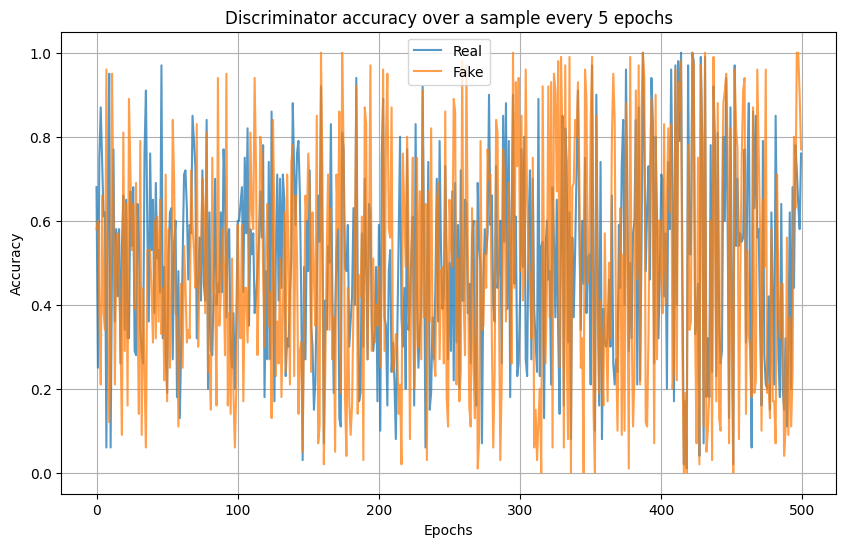

In [ ]:
g_losses, d_losses, real_accuracy_v, fake_accuracy_v = train_gan(generator, discriminator, dataset_torch, epochs, latent_dim)
print('✅')

plt.figure(figsize=(10, 6))
plt.plot(d_losses, label='Discriminator Loss', alpha=0.75)
plt.plot(g_losses, label='Generator Loss', alpha=0.75)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('GAN Losses During Training')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(real_accuracy_v, label='Real', alpha=0.75)
plt.plot(fake_accuracy_v, label='Fake', alpha=0.75)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator accuracy over a sample every 5 epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define save directory
torch.save(generator.state_dict(), os.path.join(save_dir, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(save_dir, 'discriminator.pth'))

metrics = {
      'g_losses': g_losses,
      'd_losses': d_losses,
      'real_accuracy_v': real_accuracy_v,
      'fake_accuracy_v': fake_accuracy_v
  }
with open(os.path.join(save_dir, 'metrics.pkl'), 'wb') as f:
  pickle.dump(metrics, f)